In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert import focuss
pp = dict(surface='white', hemi='both')

# Get Forward Model

In [2]:
info = get_info(kind='biosemi256')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished


# Get sample data

In [3]:
settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
# settings = dict(number_of_sources=3, extents=(25, 40), duration_of_trial=0.01, target_snr=9999999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
M = evoked.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Using pyvista 3d backend.

Using control points [1.19372454e-11 4.32099786e-11 1.09895122e-09]


# Minimum Norm Estimate

In [4]:
alpha = 0.001
# if n_chans>n_dipoles:
# D_MNE = np.linalg.inv(leadfield.T @ leadfield + alpha * np.identity(n_dipoles)) @ leadfield.T @ M
# else:
D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M


stc_hat = stc.copy()
stc_hat.data = D_MNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE', 'title',
               font_size=14)

Using control points [7.98699405e-11 1.05364682e-10 5.62564541e-10]


# Weighted Minimum Norm Estimate

In [5]:
alpha = 0.001
omega = np.diag(np.linalg.norm(leadfield, axis=0))
I_3 = np.identity(3)
W = omega # np.kron(omega, I_3)

D_WMNE = np.linalg.inv(W.T @ W) @ leadfield.T  @ np.linalg.inv(leadfield @ np.linalg.inv(W.T @ W) @ leadfield.T + alpha * np.identity(n_chans)) @ M

stc_hat = stc.copy()
stc_hat.data = D_WMNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'wMNE', 'title',
               font_size=14)

Using control points [2.53573607e-11 3.67828623e-11 1.77285953e-10]


# MNE with FOCUSS (Focal underdetermined system solution)

In [6]:
alpha = 0.001

D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M
D_FOCUSS = focuss(D_MNE, M, leadfield, alpha)



stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE FOCUSS', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Using control points [8.88134065e-68 4.81118397e-67 1.59770918e-62]
0.19491205511132137


[0.19495083398917257,
 0.1948744639497013,
 0.19490255468197829,
 0.19491950056377214,
 0.1949726994104011,
 0.19487895466277172,
 0.1949046096588706,
 0.1949585484140392,
 0.19493599130862246,
 0.1948839958105547]

# LORETA

In [7]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
# D_LOR = np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ (leadfield @ np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T + alpha * np.identity(n_chans) ) @ M


stc_hat = stc.copy()
stc_hat.data = D_LOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LORETA', 'title',
            font_size=14)



-- number of adjacent vertices : 1284
Using control points [8.22159134e-11 1.09867952e-10 2.81970069e-10]


# LORETA FOCUSS

In [8]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
D_FOCUSS = focuss(D_LOR, M, leadfield, alpha)


stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LORETA FOCUSS', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Using control points [2.03651304e-67 1.21299244e-66 1.70233688e-63]
0.15339098252114475


[0.1533904083440212,
 0.1533908864447636,
 0.15339077859320976,
 0.15339117070865352,
 0.1533908250192617,
 0.1533910785975259,
 0.1533905574933741,
 0.1533911663410368,
 0.15339134190617137,
 0.15339109710797566]

# sLORETA

In [9]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
D_MNE = K_MNE @ M
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

stc_hat = stc.copy()
stc_hat.data = D_SLOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'sLORETA', 'title',
            font_size=14)

Using control points [1.75833717e-10 2.23183801e-10 7.05757968e-10]


C:\Users\Lukas\AppData\Local\Temp/ipykernel_14448/719602940.py:8: RuntimeWarning: invalid value encountered in sqrt
  W_slor = np.sqrt(W_slor)


# sLORETA FOCUSS

In [ ]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
D_MNE = K_MNE @ M
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

D_SLOR_FOCUSS = focuss(D_SLOR, M, leadfield, alpha)

stc_hat = stc.copy()
stc_hat.data = D_SLOR_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'sLORETA FOCUSS', 'title',
            font_size=14)

# eLORETA

In [10]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
D_ELOR = K_elor @ M



stc_hat = stc.copy()
stc_hat.data = D_ELOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'eLORETA', 'title',
            font_size=14)


Optimizing eLORETA weight matrix W...
	rep 1
averagePercentChange=63.99 %
	rep 2
averagePercentChange=35.95 %
	rep 3
averagePercentChange=17.91 %
	rep 4
averagePercentChange=8.64 %
	rep 5
averagePercentChange=4.15 %
	rep 6
averagePercentChange=2.01 %
	rep 7
averagePercentChange=0.98 %
	rep 8
averagePercentChange=0.48 %
	...converged...
	...done!
Using control points [6.64210210e-11 8.94280445e-11 4.72785196e-10]


# eLORETA FOCUSS

In [11]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

# D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
# K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
# D_ELOR = K_elor @ M
d_ELOR_FOCUSS = focuss(D_ELOR, M, leadfield, alpha)


stc_hat = stc.copy()
stc_hat.data = D_ELOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'eLORETA FOCUSS', 'title',
            font_size=14)


Using control points [6.64210210e-11 8.94280445e-11 4.72785196e-10]


# S-MAP
tbd

# Saved for later

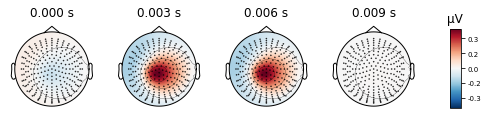

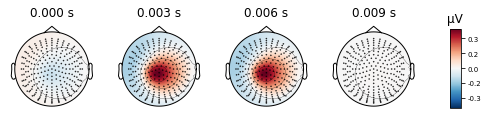

In [12]:
from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc_hat, fwd, info, tmin=stc.tmin)
evoked_hat.plot_topomap()

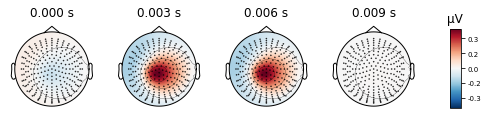

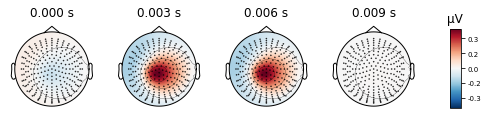

Using control points [3.39637118e-12 1.26302463e-11 2.11773456e-10]
Using control points [1.78010178e-11 2.28881894e-11 1.00802570e-10]
Using control points [5.56738017e-12 8.89351507e-12 3.53229075e-11]
Using control points [9.75244567e-74 5.48385852e-73 1.00776241e-68]
Using control points [1.94854929e-11 2.43220189e-11 4.71055162e-11]
Using control points [1.79811866e-73 9.11508197e-73 2.46349938e-70]
Using control points [3.83210392e-11 4.84700304e-11 1.25899660e-10]
Using control points [1.46636385e-11 2.07001377e-11 8.91563869e-11]
Using control points [1.46636385e-11 2.07001377e-11 8.91563869e-11]
Using control points [1.46636385e-11 2.07001377e-11 8.91563869e-11]


In [13]:
evoked.plot_topomap()